# Parte 0 - Instalação (usando Anaconda Python)

Abaixo estão os comandos usados para instalar todas as dependências necessárias para esta aula. Se você não tem uma GPU NVidia troque `tensorflow-gpu` por `tensorflow`.

    > conda create -n CV-NN python=3.7
    > conda activate CV-NN
    > conda install tensorflow-gpu scikit-learn jupyter[notebook] numpy matplotlib

Os comandos acima criam um ambiente virtual com Python 3.7. Isto não é necessário, mas pode ser interessante para organizar melhor as dependências dos seus projetos. Uma vantagem de usar o Anaconda é que ele já instala o CUDA SDK automaticamente (no caso de usar `tensorflow-gpu`). 

**Importante**: a versão dos drivers NVidia para Ubuntu 18.04 provavelmente não são suficientes para rodar o tensorflow mais recente (que usaremos na disciplina). Confira o [guia de uso de GPUs](https://www.tensorflow.org/install/gpu) para garantir que está tudo OK antes de perder muito tempo com isto.

Se você não tem GPU (ou não quer configurar nada) pode usar o [Google Colab](https://colab.research.google.com). Ele já vem com as dependências instaladas e tem GPUs disponíveis para uso gratuito. É bom para usos educacionais e nossa aula (deveria) funciona(r) nele sem problemas. 

# Parte 1 - Classificação categórica

Na última atividade vimos um exemplo de **classificação binária**, em que classificamos imagens em pertencendo ou não a uma classe (*cachorros* vs *faces*). Nesta atividade exercitaremos a classificação em categorias e para isto usaremos um modelo que se adapta bem a este tipo de situação: *Regressão logística* e a *entropia categórica*.

Além do scikit-learn, usado no roteiro passado, neste roteiro usaremos também a biblioteca [keras](http://keras.io) para treinar redes neurais que façam a classificação categórica de imagens de dígitos manuscritos. Veja abaixo o código para carregar os dados e um exemplo de imagem que usaremos.

11493376/11490434 [==============================] - 0s 0us/step
# Imagens: 60000
Tamanho: (28, 28)
Primeiro número: 5


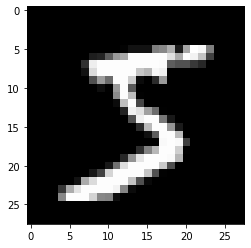

In [0]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

(X, y), (Xt, yt) = mnist.load_data()
print('# Imagens:', y.shape[0])
print('Tamanho:', X[0].shape)
print('Primeiro número:', y[0])
plt.imshow(X[0], cmap='gray')

Assim como na Atividade 3, dividimos as imagens disponíveis em um conjunto conhecido que usaremos para o treinamento de nossa rede (`X` e `y`) e um conjunto que só usaremos para avaliação (`Xt, yt`). Isto ajuda a não subestimar o erro em imagens desconhecidas. 

Nesta primeira parte iremos criar um modelo diretamente usando Regressão Logística. Para isto precisamos "deitar" a matriz da imagem $28\times 28$ em um grande vetor de dimensão $784$. 

**Exercício**: Faça isto abaixo e salve os dados transformados como `Xlr` e `Xtlr`.

In [0]:
import numpy as np

Xlr = np.reshape(X, (60000, 784))
Xtlr = np.reshape(Xt, (10000, 784))

A classe `sklearn.linear_model.LogisticRegression` é capaz de lidar com os rótulos das classes diretamente. Basta enviar o vetor `y` diretamente para a função de treinamento. 

**Dica**: para usarmos o modelo visto em sala de aula precisamos setar o parâmetro `multi_class` como `'multinomial'`. O treinamento é mais rápido se usarmos o solver `'saga'`

**Aviso**: o treinamento do modelo abaixo demora cerca de 5 minutos.

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(Xlr, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Como visto na expositiva, a *Regressão Logística* estima a probabilidade que um objeto seja de uma determinada classe. No caso dos dígitos temos 10 classes (`0` a `9`), logo nossa saída deverá ter dimensão 10 e cada componente deverá conter a probabilidade da imagem ter o dígito correspondente. 

O método `predict_proba(X)` calcula a probabilidade de cada classe para um conjunto de imagens passado em `X` (um por linha). 

**Pergunta**: suponha que seu classificador retornou, para a imagem acima, o seguinte vetor ao chamar `predict_proba`:

`[0, 0, 0, 0, 0, 0.6, 0.3, 0, 0, 0.1]`

Interprete o resultado obtido.

há 60% de chance da imagem ser um "5", 30% de ser um "6", 10% de ser um "9" e 0% do resto.

**Exercício**: selecione uma imagem qualquer do conjunto de treinamento. Plote-a abaixo (usando os comandos da primeira céclula), classifique-a usando o classificador treinado acima e interprete o resultado obtido. Ele foi bom?

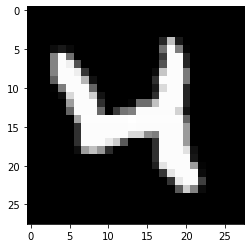

In [0]:
plt.imshow(X[20], cmap='gray')

In [0]:
clf.predict_proba([Xlr[20]])

array([[3.30415185e-09, 1.16307474e-13, 4.74977597e-06, 1.00397272e-05,
        9.99947425e-01, 6.16494591e-11, 2.56048755e-06, 6.04324452e-09,
        2.91277943e-05, 6.08776829e-06]])

**Exercício**: Assim como feito na atividade 3, avalie os resultados de seu classificador usando a função `score` e comente os resultados.

In [0]:
clf.score(Xtlr, yt)

0.9257

Considerando o quão simples o método é, um acerto de 92.5% para imagens desconhecidas é consideravelmente alto, mas para o problema do cep, com 5 digitos, a acurácia cai para 65%, o que não é satisfatório.

**Exercício**: Suponha que você precisa ler um número de 5 dígitos. Usando o classificador acima, qual seria a probabilidade de que este número seja lido corretamente? Este resultado é satisfatório?

*Sua resposta aqui*

# Parte 2 - Redes Neurais Multi-nível

**Aviso**: nos próximos exercícios usaremos a biblioteca [keras]

Nesta parte iremos criar uma rede neural "simples" com vários níveis. Diferentemente do classificador do *Scikit-learn*, ao trabalhar com redes neurais precisamos trabalhar com as probabilidades de maneira explícita. Para isto precisamos transformar nosso vetor de saída (que contém o número escrito na imagem) em uma matriz de classes binária.

**Exercício**: Pesquise o que é uma matriz de classes binária (também conhecida como *one hot encoding*)

um vetor que indica a qual classe o input pertence, crescendo de tamanho conforme o número de inputs diferentes. Ex: 1 para pessoa e -1 para cachorro.

**Exercício**: Use a função `to_categorical` do keras para converter `y` para uma matriz de classes binária `y_oe`. Faça o mesmo com `yt`

In [0]:
from keras.utils import to_categorical

y_oe = to_categorical(y, 10)
yt_oe = to_categorical(yt, 10)

Using TensorFlow backend.


**Exercício**: os dados das imagens estão no intervalo $[0,255]$. Transforme-os para estarem no intervalor $[0, 1]$. Redes neurais tem melhor desempenho no intervalo menor. Salve os dados como `Xnn` e `Xtnn`

In [0]:
Xnn = Xlr/255
Xtnn = Xtlr/255

Nossa rede neural irá retornar, como saída, um vetor de dimensão 10 igual as linhas de `y_oe`.

----

Vamos agora construir a arquitetura de nossa rede neural. Seguiremos as seguintes instruções:

1. Nosso modelo será representado pela classe `Sequential`, que é uma lista de camadas tal que a saída de uma camada é passada diretamente para a próxima.
1. Cada camada será do tipo `Dense`, ou seja, cada nó da camada está ligado a todos os nós da camada anterior. A função de ativação usada será `'relu'.`
1. A saída será uma camada `Dense` também, mas com ativação `'softmax'`. Esta função de ativação computa as mesmas probabilidades da Regressão Logística.


**Exercício**: instancie um objeto de `Sequential` e use seu método `add()` para adicionar uma camada densa de tamanho $784$ e uma camada densa de saída. 

**Dica**: 
1. veja os exemplos no [Getting Started](https://www.tensorflow.org/guide/keras/overview) do Keras/Tensorflow.
2. Ao adicionar a primeira camada é preciso dizer qual é o tamanho da entrada da rede. Isto pode ser feito usando o argumento `input_dim` de `Dense()`
2. `Sequential.add()` é capaz de adivinhar o tamanho da entrada das próximas camadas baseado nos parâmetros passados. 
3. A camada de saída deve ter tamanho igual ao número de classes usadas (10, uma para cada dígito).

In [0]:
from tensorflow.keras import layers
import tensorflow as tf

model = tf.keras.Sequential()
model.add(layers.Dense(784, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Com nosso modelo pronto precisamos definir quais serão as opções usadas em seu treinamento. Fazemos isto com o método `compile`. A chamada abaixo já foi configurada supondo que sua rede se chama `model`.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Vamos então treinar nosso modelo. Seguimos o mesmo padrão do *scikit-learn*, ou seja, chamamos o método `fit` com os dados de treinamento `Xlr` e `y_oe`. Iremos treinar com os seguintes argumentos: `batch_size=200, epochs=10`. Se quiser ter um relatório detalhado do progresso, adicione `verbose=2`.

In [0]:
model.fit(Xnn, y_oe, batch_size = 200, epochs = 10, verbose = 2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples
Epoch 1/10
60000/60000 - 2s - loss: 0.2800 - acc: 0.9200
Epoch 2/10
60000/60000 - 1s - loss: 0.1104 - acc: 0.9681
Epoch 3/10
60000/60000 - 1s - loss: 0.0720 - acc: 0.9788
Epoch 4/10
60000/60000 - 1s - loss: 0.0500 - acc: 0.9857
Epoch 5/10
60000/60000 - 1s - loss: 0.0359 - acc: 0.9898
Epoch 6/10
60000/60000 - 1s - loss: 0.0260 - acc: 0.9937
Epoch 7/10
60000/60000 - 1s - loss: 0.0191 - acc: 0.9953
Epoch 8/10
60000/60000 - 1s - loss: 0.0159 - acc: 0.9961
Epoch 9/10
60000/60000 - 1s - loss: 0.0119 - acc: 0.9974
Epoch 10/10
60000/60000 - 1s - loss: 0.0086 - acc: 0.9982


**Exercício**: Use o método [`model.evaluate`](https://keras.io/models/model/#evaluate) para avaliar a rede neural treinada e avalie seus resultados levando em conta a mesma situação da Parte 1 (leitura de número com 5 dígitos).

In [0]:
model.evaluate(Xtnn, yt_oe)

10000/10000 [==============================] - 1s 84us/sample - loss: 0.0635 - acc: 0.9835


[0.06349852646478685, 0.9835]

Isso resultou em 98.15% de acurácia, o que gera um acerto de 91% dos casos no problema do CEP.

# Parte 3 - Redes Convolucionais

Redes convolucionais são redes neurais cujas camadas fazem operações que podem ser interpretadas como processamentos de imagens.

* Conv2D - equivale a uma convolução, ou seja, uma combinação linear dos pixels na vizinhança de cada pixel
* MaxPooling2d - equivale a redimensionar a imagem para metade de sua altura e largura.
* Flatten - transforma a imagem em um vetor unidimensional. 

Redes Convolucionais são, normalmente, bastante complexas. Por isto nesta parte da atividade iremos trabalhar em cima de uma rede pré-configurada. Nossos exercícios serão treiná-la com um número crescente de épocas e adicionar ou remover camadas. 

Veja abaixo uma rede contendo uma camada de cada um dos tipos mostrados acima. 

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


model_cnn = Sequential()

model_cnn.add(layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Assim como a rede anterior, este modelo depende dos dados estarem em um formato específico. As imagens devem estar no formato $(H, W, C)$, onde $C$ é o número de canais (1 para níveis de cinza, 3 para RGB) e $H$ e $W$ são a altura e largura da imagem. O treinamento é feito usando o método `model_cnn.fit`, igual ao exercício anterior.

**Exercício**: faça o treinamento da rede acima para 1 época.

In [0]:
Xcnn = Xnn.reshape(Xnn.shape[0], 28, 28, 1).astype('float32')
Xtcnn = Xtnn.reshape(Xtnn.shape[0], 28, 28, 1).astype('float32')

model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 1)

Train on 60000 samples, validate on 10000 samples
60000/60000 - 5s - loss: 0.2280 - acc: 0.9353 - val_loss: 0.0775 - val_acc: 0.9773


**Exercício**: faça agora o treinamento para 10 épocas. Os resultados melhoraram?

In [0]:
model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 2s - loss: 0.0646 - acc: 0.9811 - val_loss: 0.0552 - val_acc: 0.9818
Epoch 2/10
60000/60000 - 2s - loss: 0.0452 - acc: 0.9863 - val_loss: 0.0480 - val_acc: 0.9846
Epoch 3/10
60000/60000 - 2s - loss: 0.0343 - acc: 0.9893 - val_loss: 0.0372 - val_acc: 0.9875
Epoch 4/10
60000/60000 - 2s - loss: 0.0276 - acc: 0.9914 - val_loss: 0.0425 - val_acc: 0.9858
Epoch 5/10
60000/60000 - 2s - loss: 0.0223 - acc: 0.9930 - val_loss: 0.0355 - val_acc: 0.9886
Epoch 6/10
60000/60000 - 2s - loss: 0.0176 - acc: 0.9947 - val_loss: 0.0366 - val_acc: 0.9896
Epoch 7/10
60000/60000 - 2s - loss: 0.0137 - acc: 0.9956 - val_loss: 0.0370 - val_acc: 0.9888
Epoch 8/10
60000/60000 - 2s - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0358 - val_acc: 0.9885
Epoch 9/10
60000/60000 - 2s - loss: 0.0099 - acc: 0.9970 - val_loss: 0.0472 - val_acc: 0.9866
Epoch 10/10
60000/60000 - 2s - loss: 0.0074 - acc: 0.9977 - val_loss: 0.0408 - val_acc: 0.9876


**Exercício**: Os parâmetros de uma camada `Conv2D` são

1. o número de filtors de convolução usados
1. a dimensão dos filtros (como uma tupla)
1. a função de ativação (sempre usaremos 'relu')

Crie um novo modelo com uma camada de convolução a mais após a camada de `MaxPooling`. Seu modelo deverá fazer 20 convoluções na primeira camada e 20 na segunda. Treine uma época do modelo e compare com o modelo de exemplos. Os resultados são melhores? E se 10 épocas forem executadas?

In [0]:
model_cnm = Sequential()

model_cnm.add(layers.Conv2D(20, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cnm.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_cnm.add(layers.Conv2D(20, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cnm.add(layers.Flatten())
model_cnm.add(layers.Dense(128, activation='relu'))
model_cnm.add(layers.Dense(10, activation='softmax'))
model_cnm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_cnm.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 1)

Train on 60000 samples, validate on 10000 samples
60000/60000 - 3s - loss: 0.2587 - acc: 0.9235 - val_loss: 0.0692 - val_acc: 0.9780


In [0]:
model_cnm.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 2s - loss: 0.0637 - acc: 0.9808 - val_loss: 0.0456 - val_acc: 0.9844
Epoch 2/10
60000/60000 - 2s - loss: 0.0443 - acc: 0.9869 - val_loss: 0.0375 - val_acc: 0.9878
Epoch 3/10
60000/60000 - 2s - loss: 0.0340 - acc: 0.9898 - val_loss: 0.0342 - val_acc: 0.9889
Epoch 4/10
60000/60000 - 2s - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0299 - val_acc: 0.9899
Epoch 5/10
60000/60000 - 2s - loss: 0.0220 - acc: 0.9933 - val_loss: 0.0287 - val_acc: 0.9899
Epoch 6/10
60000/60000 - 2s - loss: 0.0179 - acc: 0.9940 - val_loss: 0.0307 - val_acc: 0.9900
Epoch 7/10
60000/60000 - 2s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0379 - val_acc: 0.9881
Epoch 8/10
60000/60000 - 2s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0280 - val_acc: 0.9912
Epoch 9/10
60000/60000 - 2s - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0371 - val_acc: 0.9907
Epoch 10/10
60000/60000 - 2s - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0342 - val_acc: 0.9904


**Exercício**: Os parâmetros de uma camada `MaxPooling2D` são

1. uma tupla contendo a vizinhança usada para fazer o redimensionamento. 

Crie um novo modelo baseado no acima que adiciona uma camada deste tipo com os mesmos parâmetros da primeira após a segunda convolução e treine uma época dele. Os resultados são melhores? E com 10 épocas? Como o tempo de treinamento é afetado?

In [0]:
model_cmm = Sequential()

model_cmm.add(layers.Conv2D(20, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cmm.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_cmm.add(layers.Conv2D(20, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cmm.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_cmm.add(layers.Flatten())
model_cmm.add(layers.Dense(128, activation='relu'))
model_cmm.add(layers.Dense(10, activation='softmax'))
model_cmm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_cmm.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 1)

Train on 60000 samples, validate on 10000 samples
60000/60000 - 2s - loss: 0.3228 - acc: 0.9088 - val_loss: 0.0989 - val_acc: 0.9720


In [0]:
model_cmm.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs = 10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 2s - loss: 0.0811 - acc: 0.9753 - val_loss: 0.0603 - val_acc: 0.9806
Epoch 2/10
60000/60000 - 2s - loss: 0.0562 - acc: 0.9833 - val_loss: 0.0465 - val_acc: 0.9846
Epoch 3/10
60000/60000 - 2s - loss: 0.0445 - acc: 0.9865 - val_loss: 0.0425 - val_acc: 0.9871
Epoch 4/10
60000/60000 - 2s - loss: 0.0366 - acc: 0.9888 - val_loss: 0.0383 - val_acc: 0.9880
Epoch 5/10
60000/60000 - 2s - loss: 0.0305 - acc: 0.9902 - val_loss: 0.0382 - val_acc: 0.9876
Epoch 6/10
60000/60000 - 2s - loss: 0.0255 - acc: 0.9924 - val_loss: 0.0324 - val_acc: 0.9893
Epoch 7/10
60000/60000 - 2s - loss: 0.0234 - acc: 0.9924 - val_loss: 0.0363 - val_acc: 0.9883
Epoch 8/10
60000/60000 - 2s - loss: 0.0205 - acc: 0.9933 - val_loss: 0.0303 - val_acc: 0.9905
Epoch 9/10
60000/60000 - 2s - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0313 - val_acc: 0.9904
Epoch 10/10
60000/60000 - 2s - loss: 0.0154 - acc: 0.9951 - val_loss: 0.0309 - val_acc: 0.9906


Testar diversas arquiteturas é uma tarefa muito comum em Visão Computacional. 

**Exercício**: Compare os resultados de sua melhor rede com os resultados das duas partes anteriores. Qual foi o ganho de acurácia no problema da leitura do número com 5 dígitos?

*Sua resposta aqui*

# Parte final

**Exercício**: tire uma foto de 5 números escritos à mão por você. Separe cada um dos números, redimensione-os para uma imagem $28\times 28$, passe cada um pelo seu melhor modelo desta aula e retorne a leitura do número por inteiro.

**Dica**: sua foto pode conter somente a folha em branco e os dígitos em preto. Você pode supor que nenhuma parte de um dígito encosta no outro e que a imagem é binarizável usando uma operação simples de limiar (*threshold*).